In [29]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# --- CONFIGURATION ---
# Path to the folder containing your .pk files
# Based on your previous script, this should be:

# RESULTS_DIR = os.path.join("/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts", "classifier_statistics", "convnext_base")


RESULTS_DIR = os.path.join("/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts", "classifier_statistics_debug", "convnext_base")


# RESULTS_DIR = os.path.join("/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts", "single_uturn_analysis_results", "convnext_base")



# The classifier name used in filenames
CLASSIFIER_NAME = "convnext_base"

# Which metric to plot? 
# Options: 'L2', 'L2_normalized', 'cosine'
METRIC_TO_PLOT = 'cosine' 

print(f"Looking for results in: {RESULTS_DIR}")

Looking for results in: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/classifier_statistics_debug/convnext_base


In [21]:
RESULTS_DIR

'/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/single_uturn_analysis_results/convnext_base'

In [30]:
def load_activation_data(results_dir, classifier_name):
    data_by_layer = {} 
    # Structure: { layer_name: { time_step: [values...] } }
    
    # Find all matching files
    pattern = os.path.join(results_dir, f"act_diff_{classifier_name}_t*.pk")
    files = glob.glob(pattern)
    
    if not files:
        print("No files found! Check your RESULTS_DIR.")
        return None, []

    sorted_time_steps = []

    for filepath in files:
        filename = os.path.basename(filepath)
        
        # Extract time step 't' from string like "act_diff_name_t100.pk"
        # Regex looks for '_t' followed by digits
        match = re.search(r'_t(\d+)\.pk', filename)
        if match:
            t = int(match.group(1))
            sorted_time_steps.append(t)
            
            with open(filepath, 'rb') as f:
                batch_data = pickle.load(f)
                
            # batch_data structure: {layer: {'L2': array, ...}, ...}
            
            for layer, metrics in batch_data.items():
                if layer not in data_by_layer:
                    data_by_layer[layer] = {}
                
                # Store the full array of values for this time step
                # We want to keep all values to compute error bars later
                data_by_layer[layer][t] = metrics
        else:
            print(f"Skipping malformed filename: {filename}")

    sorted_time_steps = sorted(list(set(sorted_time_steps)))
    print(f"Found data for time steps: {sorted_time_steps}")
    print(f"Found {len(data_by_layer)} layers.")
    
    return data_by_layer, sorted_time_steps

raw_data, time_steps = load_activation_data(RESULTS_DIR, CLASSIFIER_NAME)

Found data for time steps: [25, 50, 75, 100, 125, 150, 175, 200, 225]
Found 41 layers.


In [31]:
def process_statistics(raw_data, time_steps, metric_key):
    plot_data = {}
    # Structure: { layer_name: {'x': [], 'y': [], 'err': []} }

    layers = list(raw_data.keys())
    
    # Determine the baseline value at t=0
    # If we compare an image to itself:
    # - L2 distance is 0.0
    # - Cosine similarity is 1.0
    if 'cosine' in metric_key:
        baseline_value = 1.0
    else:
        # L2, L2_normalized, etc.
        baseline_value = 0.0

    for layer in layers:
        means = []
        errors = []
        valid_steps = []
        
        # --- 1. Add the t=0 (Clean vs Clean) Baseline ---
        valid_steps.append(0)
        means.append(baseline_value)
        errors.append(0.0) # Zero error for identical comparison
        
        # --- 2. Process the actual data ---
        for t in time_steps:
            if t in raw_data[layer]:
                values = raw_data[layer][t][metric_key]
                
                # Compute statistics
                mean_val = np.mean(values)
                # Standard Error of the Mean (SEM)
                sem_val = np.std(values) / np.sqrt(len(values))
                
                means.append(mean_val)
                errors.append(sem_val)
                valid_steps.append(t)
        
        # Only save if we have data points beyond just the baseline
        if len(means) > 1:
            plot_data[layer] = {
                'x': valid_steps,
                'y': means,
                'err': errors
            }
            
    return plot_data

# Process the data
plot_data = process_statistics(raw_data, time_steps, METRIC_TO_PLOT)
print(f"Processed stats for {len(plot_data)} layers. Added t=0 baseline.")

Processed stats for 41 layers. Added t=0 baseline.


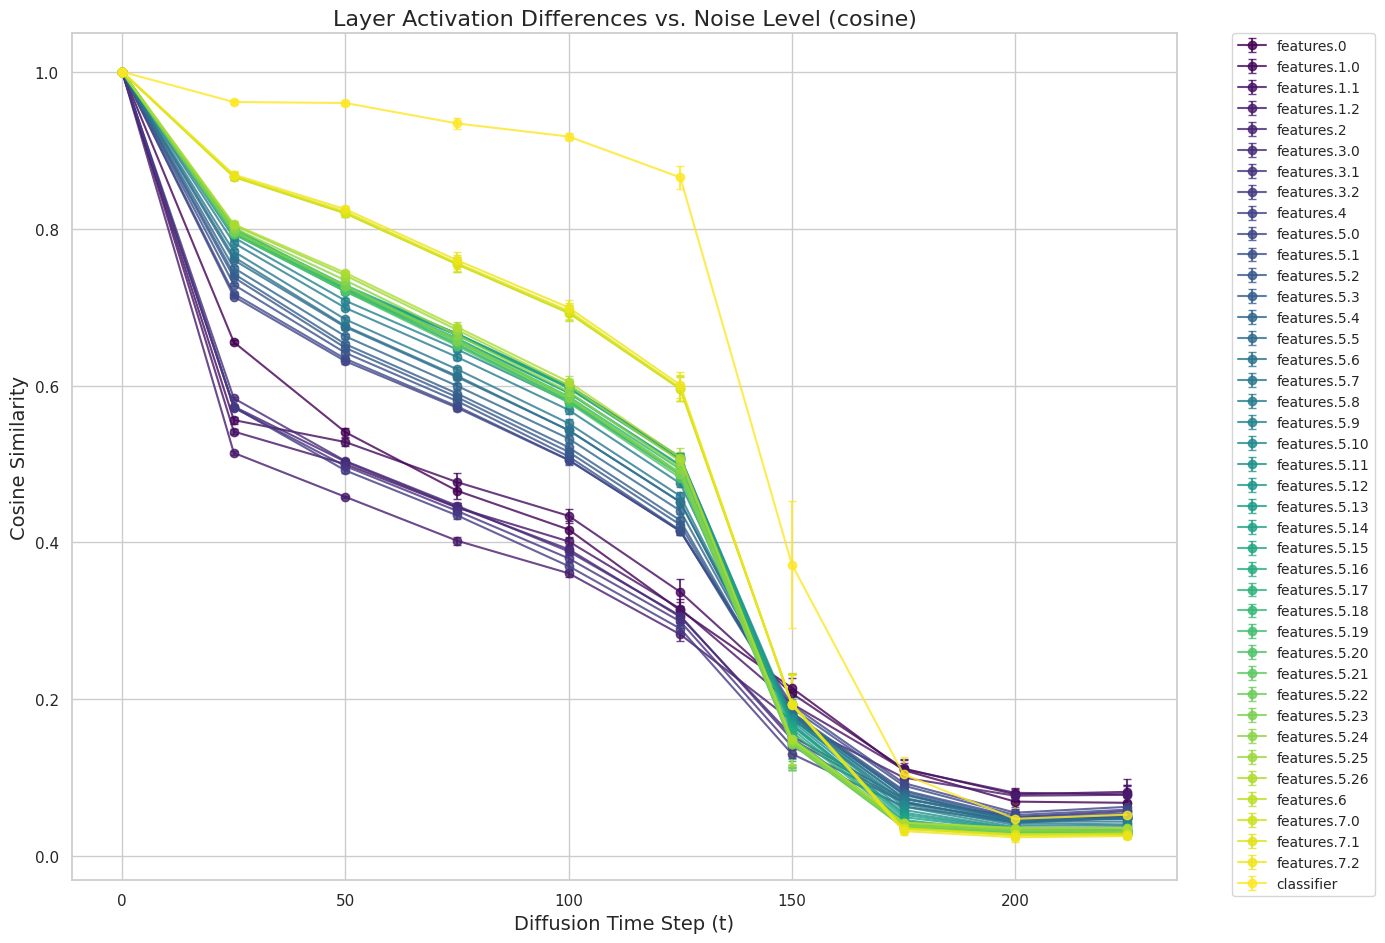

In [32]:
if plot_data:
    plt.figure(figsize=(14, 10))
    
    # Use a colormap to distinguish depth if possible, or just cycle colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
    
    for i, (layer, data) in enumerate(plot_data.items()):
        plt.errorbar(
            data['x'], 
            data['y'], 
            yerr=data['err'], 
            marker='o', 
            capsize=3, 
            label=layer,
            color=colors[i],
            alpha=0.8
        )

    plt.title(f"Layer Activation Differences vs. Noise Level ({METRIC_TO_PLOT})", fontsize=16)
    plt.xlabel("Diffusion Time Step (t)", fontsize=14)
    
    # Dynamic Y-label based on metric
    if METRIC_TO_PLOT == 'cosine':
        plt.ylabel("Cosine Similarity", fontsize=14)
        # Invert axis for cosine? Usually 1 is good, 0 is bad. 
        # Or maybe you plotted 1-cosine?
    elif 'normalized' in METRIC_TO_PLOT:
        plt.ylabel("Normalized L2 Distance", fontsize=14)
    else:
        plt.ylabel("L2 Distance", fontsize=14)

    # Put legend outside if there are too many layers
    if len(plot_data) > 10:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
    else:
        plt.legend()
        
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

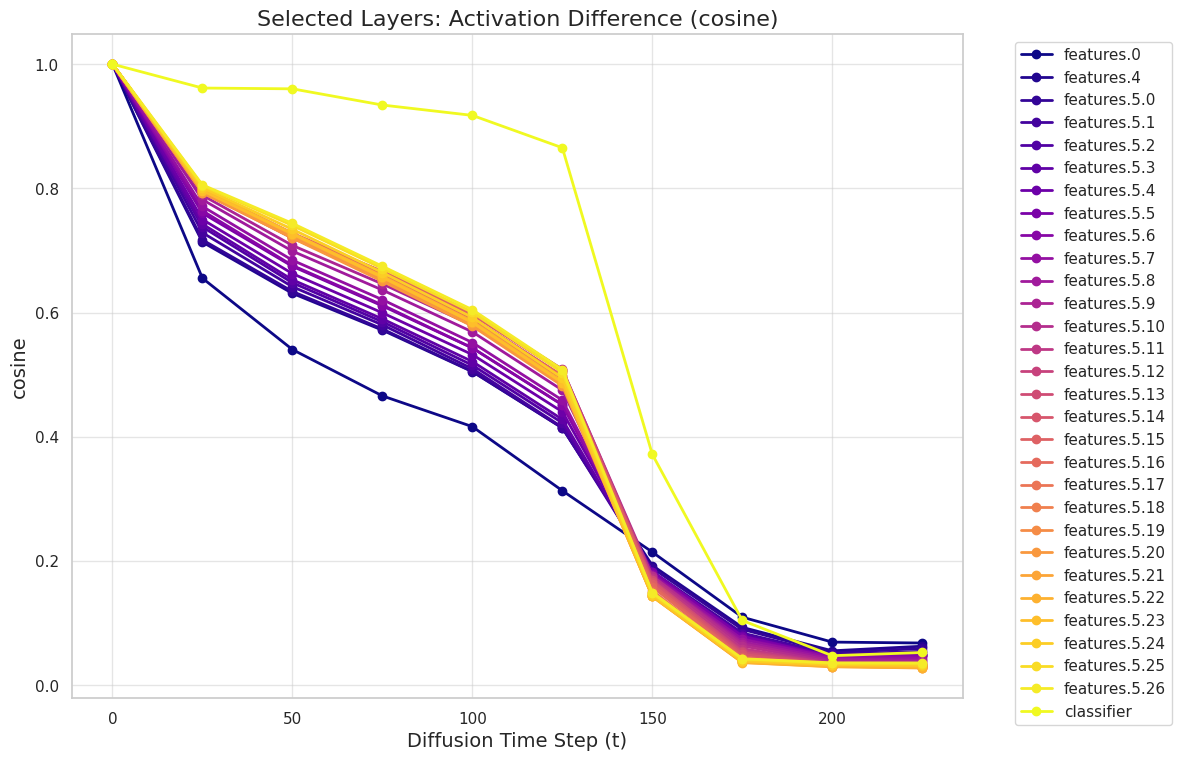

In [33]:
# --- FILTER CONFIG ---
# Keywords to keep. For ConvNeXt/ResNet, these are usually 'stages', 'blocks', 'downsample', etc.
# Adjust these keywords based on the layer names printed in Cell 2.
# KEYWORDS_TO_KEEP = ["stages.0", "stages.1", "stages.2", "stages.3", "head"] 
# Or specific layers if you know them:
KEYWORDS_TO_KEEP = ["features.0", "features.4", "features.5", "classifier"]

if plot_data:
    plt.figure(figsize=(12, 8))
    
    filtered_items = {k: v for k, v in plot_data.items() if any(sub in k for sub in KEYWORDS_TO_KEEP)}
    colors = plt.cm.plasma(np.linspace(0, 1, len(filtered_items)))

    for i, (layer, data) in enumerate(filtered_items.items()):
        plt.plot(
            data['x'], 
            data['y'], 
            marker='o', 
            label=layer,
            color=colors[i],
            linewidth=2
        )

    plt.title(f"Selected Layers: Activation Difference ({METRIC_TO_PLOT})", fontsize=16)
    plt.xlabel("Diffusion Time Step (t)", fontsize=14)
    plt.ylabel(METRIC_TO_PLOT, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.tight_layout()
    plt.show()

Looking for results in: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/classifier_statistics_debug/convnext_base
✅ Found data for 9 time steps: [25, 50, 75, 100, 125, 150, 175, 200, 225]
Processed stats for 41 layers.


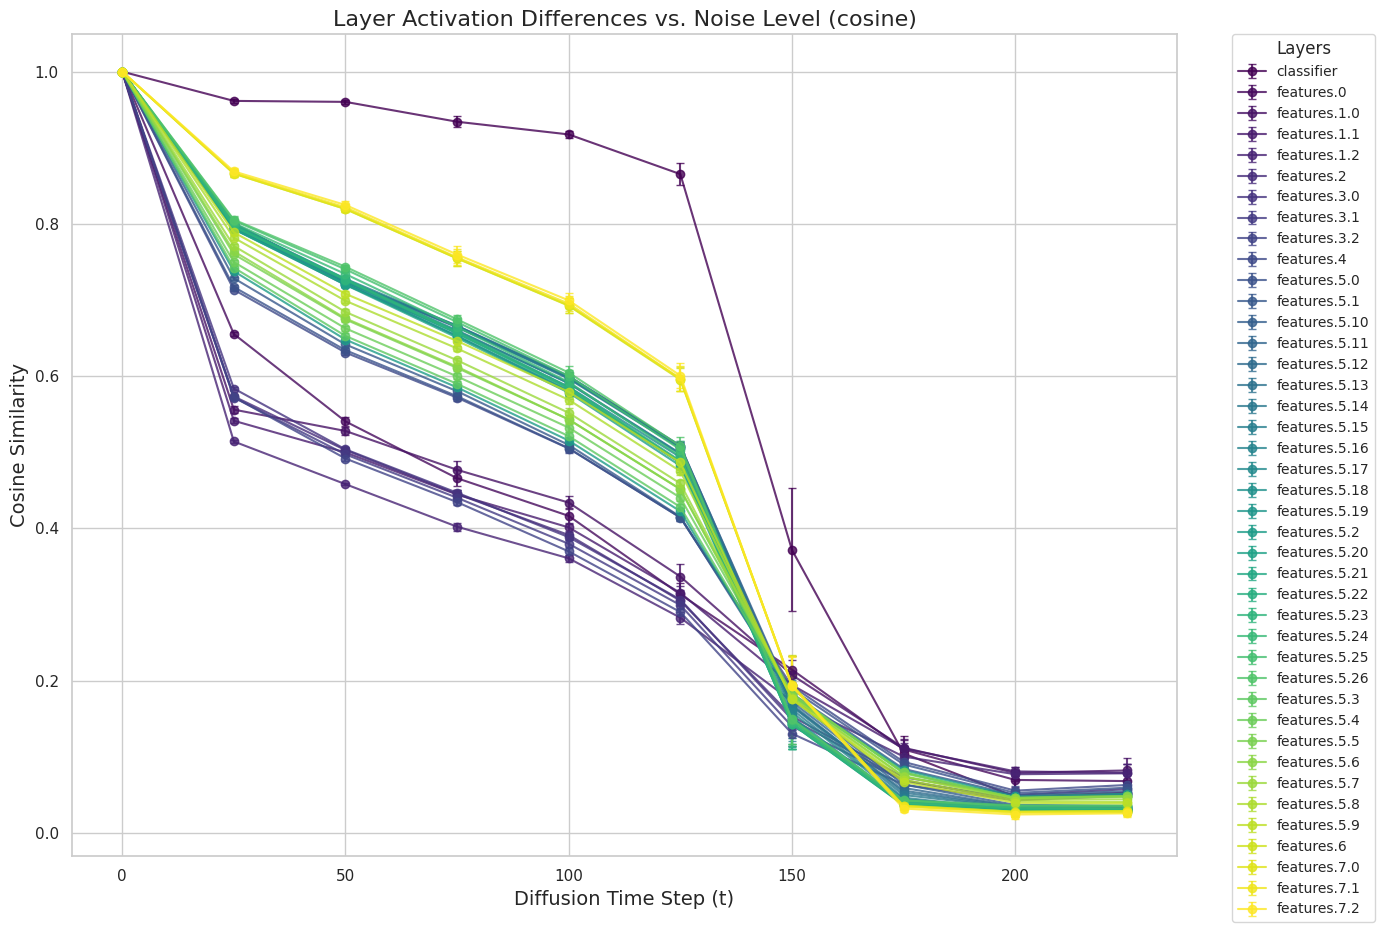

In [28]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# --- CONFIGURATION ---

# 1. Update the path to point to your NEW debug results
#    The evaluation script saved them in 'classifier_statistics_debug/convnext_base'
RESULTS_DIR = os.path.join(
    "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts", 
    "classifier_statistics_debug", 
    "convnext_base"
)



# 2. Classifier Name
CLASSIFIER_NAME = "convnext_base"

# 3. Metric
METRIC_TO_PLOT = 'cosine' 

print(f"Looking for results in: {RESULTS_DIR}")

# --- DATA LOADING (Same as before) ---
def load_activation_data(results_dir, classifier_name):
    data_by_layer = {} 
    
    # Find all matching files
    pattern = os.path.join(results_dir, f"act_diff_{classifier_name}_t*.pk")
    files = glob.glob(pattern)
    
    if not files:
        print("❌ No files found! Check your RESULTS_DIR path.")
        return None, []

    sorted_time_steps = []

    for filepath in files:
        filename = os.path.basename(filepath)
        match = re.search(r'_t(\d+)\.pk', filename)
        if match:
            t = int(match.group(1))
            sorted_time_steps.append(t)
            
            with open(filepath, 'rb') as f:
                batch_data = pickle.load(f)
            
            for layer, metrics in batch_data.items():
                if layer not in data_by_layer:
                    data_by_layer[layer] = {}
                data_by_layer[layer][t] = metrics
        else:
            print(f"Skipping malformed filename: {filename}")

    sorted_time_steps = sorted(list(set(sorted_time_steps)))
    print(f"✅ Found data for {len(sorted_time_steps)} time steps: {sorted_time_steps}")
    return data_by_layer, sorted_time_steps

raw_data, time_steps = load_activation_data(RESULTS_DIR, CLASSIFIER_NAME)

# --- STATISTICS PROCESSING (Same as before) ---
def process_statistics(raw_data, time_steps, metric_key):
    plot_data = {}
    if not raw_data: return {}
    
    layers = list(raw_data.keys())
    
    # Determine baseline (t=0)
    if 'cosine' in metric_key:
        baseline_value = 1.0
    else:
        baseline_value = 0.0

    for layer in layers:
        means = []
        errors = []
        valid_steps = []
        
        # Add t=0 baseline
        valid_steps.append(0)
        means.append(baseline_value)
        errors.append(0.0) 
        
        for t in time_steps:
            if t in raw_data[layer]:
                values = raw_data[layer][t][metric_key]
                
                mean_val = np.mean(values)
                if len(values) > 1:
                    sem_val = np.std(values) / np.sqrt(len(values))
                else:
                    sem_val = 0.0 # No error bar if only 1 sample
                
                means.append(mean_val)
                errors.append(sem_val)
                valid_steps.append(t)
        
        if len(means) > 1:
            plot_data[layer] = {'x': valid_steps, 'y': means, 'err': errors}
            
    return plot_data

plot_data = process_statistics(raw_data, time_steps, METRIC_TO_PLOT)
print(f"Processed stats for {len(plot_data)} layers.")

# --- PLOTTING ---
if plot_data:
    plt.figure(figsize=(14, 10))
    
    # Optional: Filter for specific layers if the plot is too crowded
    # LAYERS_TO_KEEP = ["stages.0", "stages.1", "stages.2", "stages.3", "head"]
    # filtered_data = {k: v for k, v in plot_data.items() if any(x in k for x in LAYERS_TO_KEEP)}
    filtered_data = plot_data # Plot all by default
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_data)))
    
    # Sort layers alphabetically or by depth if possible for cleaner legend
    sorted_layers = sorted(filtered_data.keys())

    for i, layer in enumerate(sorted_layers):
        data = filtered_data[layer]
        plt.errorbar(
            data['x'], 
            data['y'], 
            yerr=data['err'], 
            marker='o', 
            capsize=3, 
            label=layer,
            color=colors[i],
            alpha=0.8
        )

    plt.title(f"Layer Activation Differences vs. Noise Level ({METRIC_TO_PLOT})", fontsize=16)
    plt.xlabel("Diffusion Time Step (t)", fontsize=14)
    
    if METRIC_TO_PLOT == 'cosine':
        plt.ylabel("Cosine Similarity", fontsize=14)
    else:
        plt.ylabel("Normalized Distance", fontsize=14)

    # Place legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small', title="Layers")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

In [24]:
import pickle
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [18, 5] # Wide figure for side-by-side panels

# --- CONFIGURATION ---
BASE_OUTPUT_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"
CLASSIFIER_NAME = "convnext_base"
IMAGE_NAME = "ILSVRC2012_val_00000729"

# The U-turn "checkpoints" to create panels for
UTURN_PANELS = [1] # 20, 50, 100]

# Layers to plot (Curves within each panel)
# Ordered from Input -> Output
LAYERS_TO_PLOT = [
    "features.0",   # Early features (Textures/Edges)
    "features.1", 
    "features.2", 
    "features.3",   # Deep features (Semantic Parts)
    "features.4",   # Deep features (Semantic Parts)
    "features.5",   # Deep features (Semantic Parts)
    "features.6",   # Deep features (Semantic Parts)
    "features.7",   # Deep features (Semantic Parts)
    "classifier"        # Final Classification (Semantic Identity)
]

print(f"Analyzing: {IMAGE_NAME}")
print(f"Panels (N): {UTURN_PANELS}")

Analyzing: ILSVRC2012_val_00000729
Panels (N): [1]


In [25]:
# 1. Discover available noise levels
search_path = os.path.join(BASE_OUTPUT_DIR, CLASSIFIER_NAME, IMAGE_NAME, "noise_*")
noise_dirs = sorted(glob.glob(search_path))

noise_map = {}
for d in noise_dirs:
    folder_name = os.path.basename(d)
    try:
        val = int(folder_name.split('_')[-1])
        pk_file = os.path.join(d, "sequential_activations_v2.pk")
        if os.path.exists(pk_file):
            noise_map[val] = pk_file
    except ValueError: pass

available_noises = sorted(noise_map.keys())
print(f"Found noise levels: {available_noises}")

# 2. Structure Data
# plot_data[uturn_count][layer] = { 'x': [noises], 'y': [means], 'err': [sems] }
plot_data = {}

# Initialize
for n in UTURN_PANELS:
    plot_data[n] = {}
    for layer in LAYERS_TO_PLOT:
        plot_data[n][layer] = {'x': [], 'y': [], 'err': []}

# Loop through noise levels
for noise in available_noises:
    filepath = noise_map[noise]
    try:
        with open(filepath, 'rb') as f:
            results = pickle.load(f)
            
        # For each target U-turn count...
        for n_turn in UTURN_PANELS:
            if n_turn not in results: continue
            
            step_data = results[n_turn]
            
            # For each target layer...
            for layer_partial in LAYERS_TO_PLOT:
                full_layer = next((k for k in step_data.keys() if layer_partial in k), None)
                
                if full_layer:
                    values = step_data[full_layer]['cosine']
                    mean_val = np.mean(values)
                    sem_val = np.std(values) / np.sqrt(len(values))
                    
                    plot_data[n_turn][layer_partial]['x'].append(noise)
                    plot_data[n_turn][layer_partial]['y'].append(mean_val)
                    plot_data[n_turn][layer_partial]['err'].append(sem_val)
                    
    except Exception as e:
        print(f"Error reading noise {noise}: {e}")

print("Data aggregation complete.")

Found noise levels: [100, 200]
Data aggregation complete.


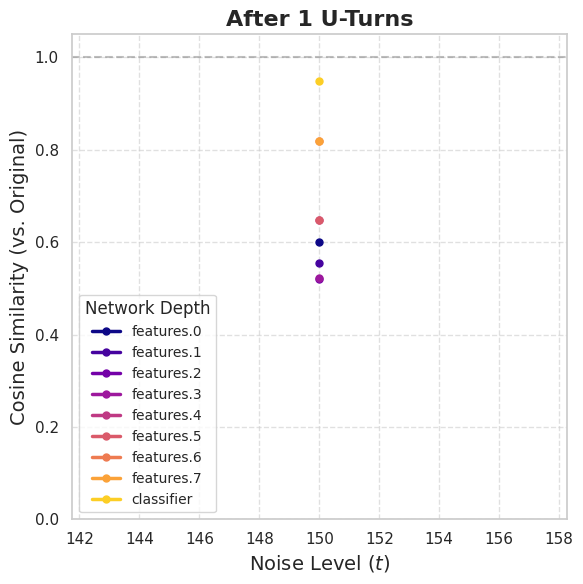

In [29]:
num_panels = len(UTURN_PANELS)
fig, axes = plt.subplots(1, num_panels, figsize=(6 * num_panels, 6), sharey=True)

# Handle single panel case
if num_panels == 1: axes = [axes]

# Define colors for layers (Cool -> Warm or Viridis)
colors = plt.cm.plasma(np.linspace(0, 0.9, len(LAYERS_TO_PLOT)))

for i, n_turn in enumerate(UTURN_PANELS):
    ax = axes[i]
    
    # Plot each layer as a separate curve
    for j, layer in enumerate(LAYERS_TO_PLOT):
        data = plot_data[n_turn][layer]
        x = np.array(data['x'])
        y = np.array(data['y'])
        err = np.array(data['err'])
        
        if len(x) == 0: continue
        
        ax.plot(x, y, marker='o', markersize=5, label=layer, color=colors[j], linewidth=2.5)
        ax.fill_between(x, y - err, y + err, color=colors[j], alpha=0.15)
    
    ax.set_title(f"After {n_turn} U-Turns", fontsize=16, fontweight='bold')
    ax.set_xlabel("Noise Level ($t$)", fontsize=14)
    if i == 0:
        ax.set_ylabel("Cosine Similarity (vs. Original)", fontsize=14)
    
    ax.set_ylim(0.0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add t=0 baseline
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)

# Add a single legend to the last plot (or outside)
axes[-1].legend(title="Network Depth", loc='lower left', fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

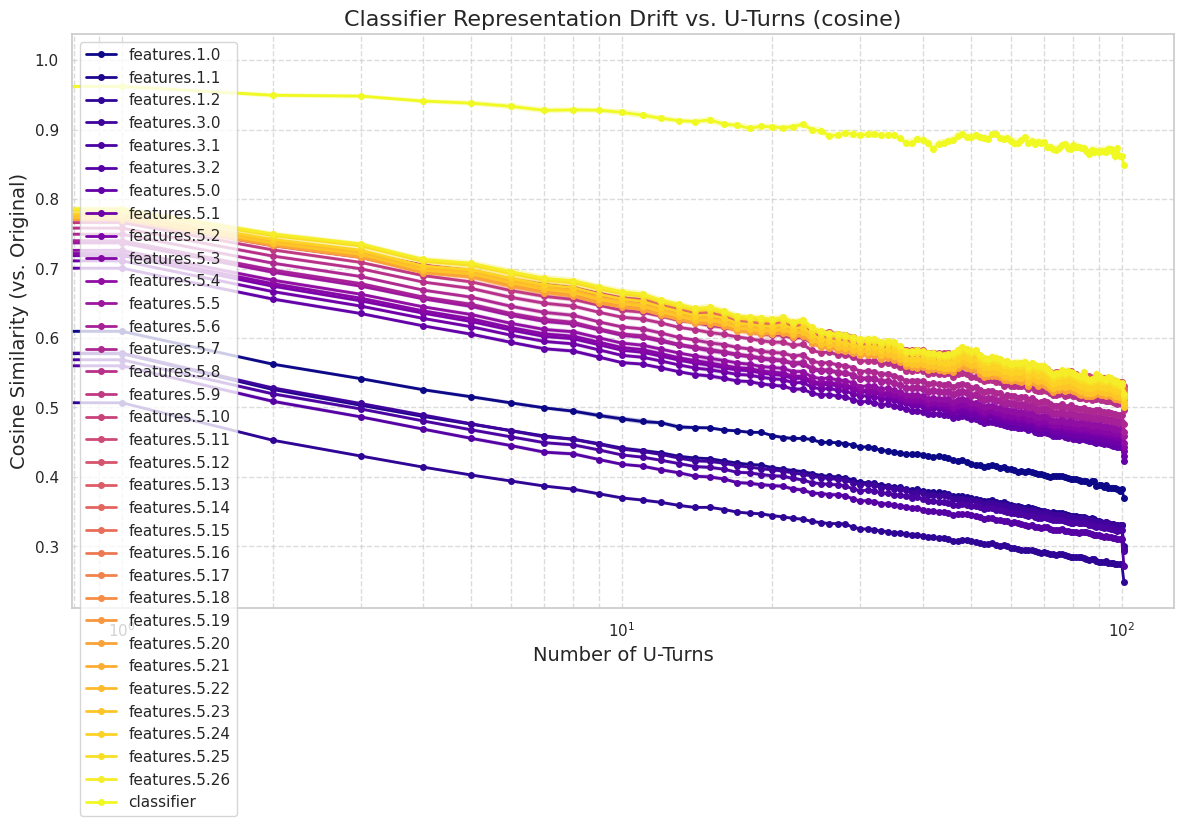

In [5]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
                           
RESULTS_FILE = os.path.join("/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts","sequential_analysis_results/convnext_base/ILSVRC2012_val_00000729/noise_100/sequential_activations_v2.pk")
KEYWORDS_TO_KEEP = ["features.5", "features.3", "features.1", "classifier"] 


import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
# Make sure to point to the new file "sequential_activations_v2.pk"
# RESULTS_FILE = "sequential_analysis_results/convnext_base/ILSVRC2012_val_00000729/noise_75/sequential_activations_v2.pk"
# KEYWORDS_TO_KEEP = ["stages.0", "stages.1", "stages.2", "stages.3", "head"] 

# Choose your metric: 'l2_norm' or 'cosine'
METRIC_TO_PLOT = 'cosine'

# --- LOAD ---
with open(RESULTS_FILE, 'rb') as f:
    results_by_step = pickle.load(f)

plot_data = {}
steps = sorted(results_by_step.keys())

# Initialize layers
first_step_key = steps[0]
first_step_data = results_by_step[first_step_key] # This is now a dict of dicts
layers = [l for l in first_step_data.keys() if any(k in l for k in KEYWORDS_TO_KEEP)]

# Determine Baseline (t=0)
if METRIC_TO_PLOT == 'cosine':
    baseline_value = 1.0 # Similarity to self is 1
    y_label = "Cosine Similarity (vs. Original)"
else:
    baseline_value = 0.0 # Distance to self is 0
    y_label = "Normalized L2 Distance (vs. Original)"

for layer in layers:
    plot_data[layer] = {'x': [0], 'y': [baseline_value], 'err': [0.0]}

    for step in steps:
        # Access the specific metric inside the dictionary
        values = results_by_step[step][layer][METRIC_TO_PLOT]
        
        mean_val = np.mean(values)
        sem_val = np.std(values) / np.sqrt(len(values))
        
        plot_data[layer]['x'].append(step)
        plot_data[layer]['y'].append(mean_val)
        plot_data[layer]['err'].append(sem_val)

# --- PLOT ---
plt.figure(figsize=(12, 8))
colors = plt.cm.plasma(np.linspace(0, 1, len(layers)))

for i, layer in enumerate(layers):
    data = plot_data[layer]
    plt.plot(
        data['x'], 
        data['y'], 
        marker='o',
        markersize=4,
        label=layer,
        color=colors[i],
        linewidth=2
    )
    plt.fill_between(
        data['x'],
        np.array(data['y']) - np.array(data['err']),
        np.array(data['y']) + np.array(data['err']),
        color=colors[i],
        alpha=0.2
    )

plt.title(f"Classifier Representation Drift vs. U-Turns ({METRIC_TO_PLOT})", fontsize=16)
plt.xlabel("Number of U-Turns", fontsize=14)
plt.ylabel(y_label, fontsize=14)
plt.xscale('log')
plt.legend(loc='best') # 'best' usually avoids covering lines
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

Available layers in file: ['features.0', 'features.1.0', 'features.1.1', 'features.1.2', 'features.2', 'features.3.0', 'features.3.1', 'features.3.2', 'features.4', 'features.5.0', 'features.5.1', 'features.5.2', 'features.5.3', 'features.5.4', 'features.5.5', 'features.5.6', 'features.5.7', 'features.5.8', 'features.5.9', 'features.5.10', 'features.5.11', 'features.5.12', 'features.5.13', 'features.5.14', 'features.5.15', 'features.5.16', 'features.5.17', 'features.5.18', 'features.5.19', 'features.5.20', 'features.5.21', 'features.5.22', 'features.5.23', 'features.5.24', 'features.5.25', 'features.5.26', 'features.6', 'features.7.0', 'features.7.1', 'features.7.2', 'classifier']


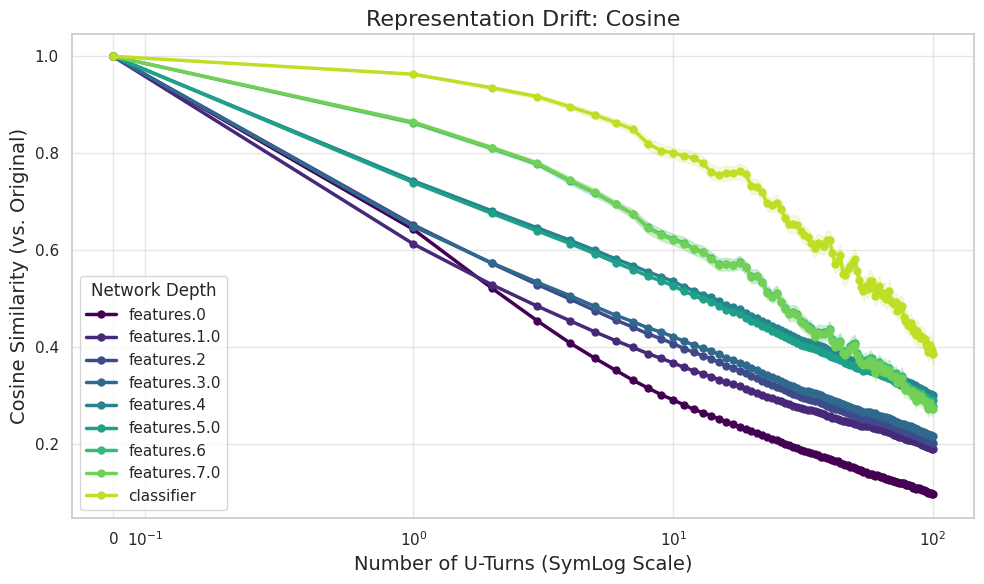

In [6]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
RESULTS_FILE = os.path.join(
    "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts",
    # "sequential_analysis_results/convnext_base/ILSVRC2012_val_00000729/noise_75/sequential_activations_v2.pk"
    # "sequential_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_150/sequential_activations_v2.pk"
    "sequential_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_100/sequential_activations_v2.pk"
)

# 1. Select specific layers (Input -> Output order recommended)
#    Adjust these names based on the "Available layers" printout if needed.
#    For ConvNeXt, standard names are often 'stem', 'stages.x', 'head'.
LAYERS_TO_PLOT = [
    "features.0",         # Close to Input
    "features.1",     # Mid-Low
    "features.2",     # Mid-High (Deep features)
    "features.3",     # Mid-High (Deep features)
    "features.4",     # Mid-High (Deep features)
    "features.5",          # Classifier Output
    "features.6",          # Classifier Output
    "features.7",          # Classifier Output
    "classifier",          # Classifier Output
]

# 2. Choose Metric
METRIC_TO_PLOT = 'cosine'

# --- LOAD DATA ---
if not os.path.exists(RESULTS_FILE):
    print(f"Error: File not found at {RESULTS_FILE}")
else:
    with open(RESULTS_FILE, 'rb') as f:
        results_by_step = pickle.load(f)

    plot_data = {}
    steps = sorted(results_by_step.keys())

    # Get available layers from the first step to help debugging
    first_step_data = results_by_step[steps[0]]
    available_layers = list(first_step_data.keys())
    print(f"Available layers in file: {available_layers}")

    # Determine Baseline (t=0)
    if METRIC_TO_PLOT == 'cosine':
        baseline_value = 1.0
        y_label = "Cosine Similarity (vs. Original)"
    else:
        baseline_value = 0.0
        y_label = "Normalized L2 Distance (vs. Original)"

    # --- PROCESS DATA ---
    # We iterate through the specific LAYERS_TO_PLOT list to maintain order
    found_layers = []
    
    for layer_name_partial in LAYERS_TO_PLOT:
        # Find the full layer name that matches our partial config string
        # e.g., "stages.0" might match "module.stages.0"
        matches = [l for l in available_layers if layer_name_partial in l]
        
        if not matches:
            print(f"Warning: Could not find layer matching '{layer_name_partial}'")
            continue
            
        # Use the first match (usually the correct one)
        full_layer_name = matches[0]
        found_layers.append(full_layer_name)
        
        plot_data[full_layer_name] = {'x': [0], 'y': [baseline_value], 'err': [0.0]}

        for step in steps:
            values = results_by_step[step][full_layer_name][METRIC_TO_PLOT]
            
            mean_val = np.mean(values)
            sem_val = np.std(values) / np.sqrt(len(values))
            
            plot_data[full_layer_name]['x'].append(step)
            plot_data[full_layer_name]['y'].append(mean_val)
            plot_data[full_layer_name]['err'].append(sem_val)

    # --- PLOT ---
    plt.figure(figsize=(10, 6))
    
    # Use a specific colormap that varies from light to dark or distinct colors
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(found_layers)))

    for i, layer in enumerate(found_layers):
        data = plot_data[layer]
        
        # Plot with error bars (shaded region)
        plt.plot(
            data['x'], 
            data['y'], 
            marker='o',
            markersize=5,
            label=layer, # Legend label
            color=colors[i],
            linewidth=2.5
        )
        plt.fill_between(
            data['x'],
            np.array(data['y']) - np.array(data['err']),
            np.array(data['y']) + np.array(data['err']),
            color=colors[i],
            alpha=0.15
        )

    # --- FORMATTING FOR LOG SCALE WITH ZERO ---
    # 'symlog' (symmetric log) allows plotting 0 on a log-like axis.
    # linthresh determines the region around 0 that is linear. 
    # Since our first step is 1, linthresh=0.9 works well to separate 0 from 1.
    plt.xscale('symlog', linthresh=0.9)
    
    plt.title(f"Representation Drift: {METRIC_TO_PLOT.capitalize()}", fontsize=16)
    plt.xlabel("Number of U-Turns (SymLog Scale)", fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    # Customize ticks to make 0 and 10^x visible
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    
    plt.legend(title="Network Depth", loc='best', fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()

In [26]:
import pickle
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# --- CONFIGURATION ---
# 1. The root folder containing your results
#    (The folder containing the 'convnext_base' folder)
BASE_OUTPUT_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"

# 2. Classifier Name (must match the folder name)
CLASSIFIER_NAME = "convnext_base"

# 3. Noise Step to analyze (must match the folder name e.g., 'noise_150')
# NOISE_STEP = 150 
NOISE_STEP = 200 

# 4. Layers to plot
#    These are substrings. Any layer name containing these strings will be plotted.
LAYERS_TO_PLOT = [
    "features.0",   # Early features (Textures/Edges)
    "features.1", 
    "features.2", 
    "features.3",   # Deep features (Semantic Parts)
    "features.4",   # Deep features (Semantic Parts)
    "features.5",   # Deep features (Semantic Parts)
    "features.6",   # Deep features (Semantic Parts)
    "features.7",   # Deep features (Semantic Parts)
    "classifier"        # Final Classification (Semantic Identity)
]

print(f"Analyzing {CLASSIFIER_NAME} at Noise Step {NOISE_STEP}...")


# NEW: Minimum number of images required to include a step in the plot
# Set this to the total number of images you processed (e.g., 50) to be strict.
# Or set it to e.g. 45 to allow for a few failures.
MIN_SAMPLES_REQUIRED = 5

Analyzing convnext_base at Noise Step 200...


In [27]:
# 1. Find all result files for this specific noise level across all images
# Pattern: base / classifier / * (any image) / noise_X / filename
search_pattern = os.path.join(
    BASE_OUTPUT_DIR, 
    CLASSIFIER_NAME, 
    "*", 
    f"noise_{NOISE_STEP}", 
    "sequential_activations_v2.pk"
)

file_list = sorted(glob.glob(search_pattern))
print(f"Found {len(file_list)} image result files.")

if len(file_list) == 0:
    raise FileNotFoundError("No files found. Check your BASE_OUTPUT_DIR and NOISE_STEP.")

# 2. Aggregation Dictionary
# Structure: global_stats[layer][step] = list of means (one per image)
global_stats = {}

for filepath in file_list:
    try:
        with open(filepath, 'rb') as f:
            # results_by_step[step][layer]['cosine'] -> array of trajectory scores
            results_by_step = pickle.load(f)
            
        steps = sorted(results_by_step.keys())
        
        # Iterate through steps (1, 2, ..., N)
        for step in steps:
            layer_data = results_by_step[step]
            
            for layer in layer_data:
                # Filter to only keep layers we care about to save memory
                if not any(target in layer for target in LAYERS_TO_PLOT):
                    continue
                
                # --- INNER AVERAGE: Over Trajectories ---
                # Get the array of cosine similarities for the 50 trajectories
                traj_scores = layer_data[layer]['cosine']
                
                # Calculate the mean for THIS image
                image_mean = np.mean(traj_scores)
                
                # Initialize structure if needed
                if layer not in global_stats:
                    global_stats[layer] = {}
                if step not in global_stats[layer]:
                    global_stats[layer][step] = []
                
                # Store this image's mean
                global_stats[layer][step].append(image_mean)
                
    except Exception as e:
        print(f"Error reading {filepath}: {e}")

print(f"Processed data for {len(global_stats)} layers.")

Found 28 image result files.
Processed data for 41 layers.


--- Checking Sample Counts per Step ---
Step 101: Dropped (Only 1 samples, threshold is 5)
Plotting steps 1 to 100 (Sample counts: 28-28)


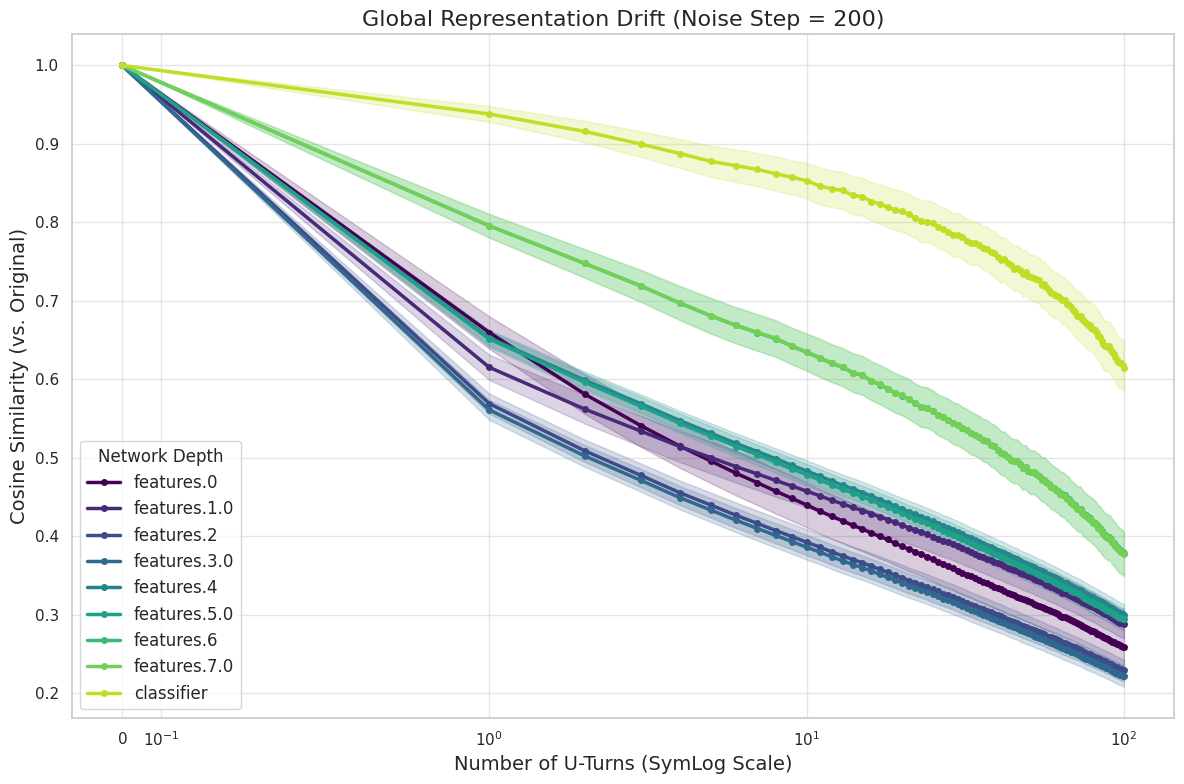

In [28]:
if not global_stats:
    print("No data to plot.")
else:
    plt.figure(figsize=(12, 8))
    
    # 1. Determine the valid range of steps (Common Support)
    # We look at one layer to count samples (counts are usually same across layers)
    test_layer = list(global_stats.keys())[0]
    all_steps = sorted(global_stats[test_layer].keys())
    
    valid_steps = []
    sample_counts = []
    
    print("--- Checking Sample Counts per Step ---")
    for step in all_steps:
        count = len(global_stats[test_layer][step])
        if count >= MIN_SAMPLES_REQUIRED:
            valid_steps.append(step)
            sample_counts.append(count)
        else:
            print(f"Step {step}: Dropped (Only {count} samples, threshold is {MIN_SAMPLES_REQUIRED})")
            # Usually, once one drops, the rest follow, so we can break or just skip
            # break 

    if not valid_steps:
        print("Error: No steps met the minimum sample requirement.")
    else:
        print(f"Plotting steps {min(valid_steps)} to {max(valid_steps)} (Sample counts: {min(sample_counts)}-{max(sample_counts)})")

        # 2. Prepare Data
        available_layers = sorted(global_stats.keys())
        ordered_layers = []
        for target in LAYERS_TO_PLOT:
            for layer in available_layers:
                if target in layer:
                    ordered_layers.append(layer)
                    break
        
        colors = plt.cm.viridis(np.linspace(0, 0.9, len(ordered_layers)))

        for i, full_layer_name in enumerate(ordered_layers):
            data_map = global_stats[full_layer_name]
            
            # Use valid_steps to ensure we only plot the consistent region
            xs = [0] + valid_steps
            ys = [1.0] 
            errs = [0.0] 
            
            for step in valid_steps:
                values = np.array(data_map[step])
                
                global_mean = np.mean(values)
                if len(values) > 1:
                    global_sem = np.std(values) / np.sqrt(len(values))
                else:
                    global_sem = 0.0
                
                ys.append(global_mean)
                errs.append(global_sem)
            
            xs = np.array(xs)
            ys = np.array(ys)
            errs = np.array(errs)
            
            plt.plot(xs, ys, marker='o', markersize=4, label=full_layer_name, color=colors[i], linewidth=2.5)
            plt.fill_between(xs, ys - errs, ys + errs, color=colors[i], alpha=0.2)

        # 3. Formatting
        plt.xscale('symlog', linthresh=0.9) 
        plt.xlabel("Number of U-Turns (SymLog Scale)", fontsize=14)
        plt.ylabel("Cosine Similarity (vs. Original)", fontsize=14)
        plt.title(f"Global Representation Drift (Noise Step = {NOISE_STEP})", fontsize=16)
        plt.legend(title="Network Depth", fontsize=12, loc='best')
        plt.grid(True, which="major", ls="-", alpha=0.5)
        plt.grid(True, which="minor", ls=":", alpha=0.2)

        plt.tight_layout()
        plt.show()

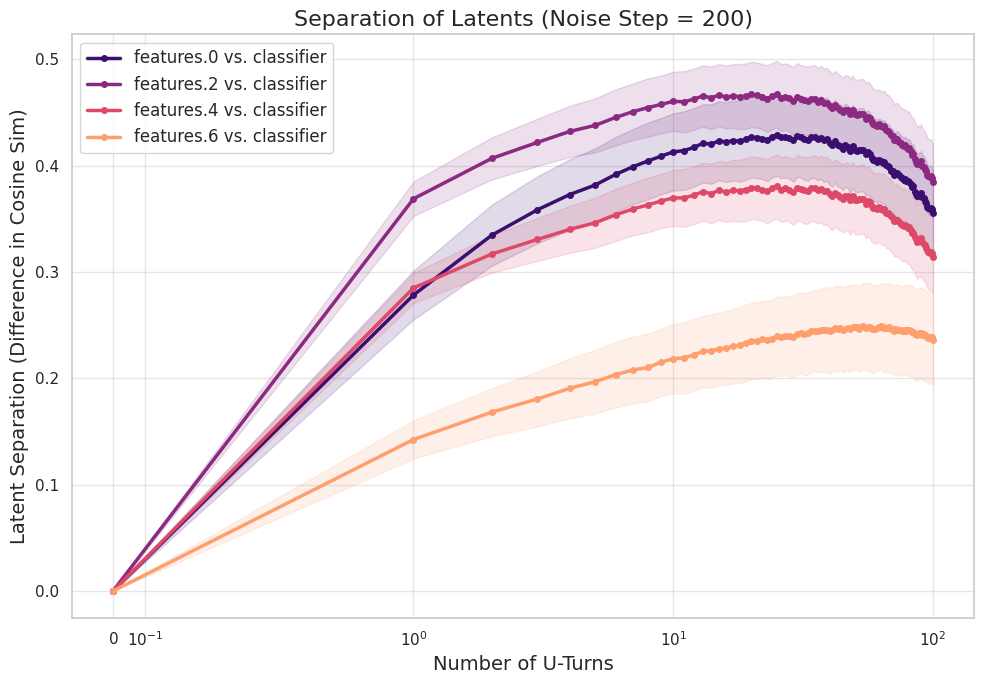

In [29]:
# --- CONFIGURATION FOR SEPARATION PLOT ---
# Define the pairs to compare: (Lower Level Layer, Higher Level Layer)
PAIRS_TO_COMPARE = [
    ("features.0", "classifier"), # Input vs Output
    ("features.2", "classifier"), # Input vs Output
    ("features.4", "classifier"), # Input vs Output
    # ("features.4", "classifier"), # Mid vs Output
    ("features.6", "classifier")  # Penultimate vs Output
]

# Ensure we have data
if not global_stats:
    print("No data loaded in global_stats. Please run the data loading cell first.")
else:
    plt.figure(figsize=(10, 7))
    colors = plt.cm.magma(np.linspace(0.2, 0.8, len(PAIRS_TO_COMPARE)))
    
    # Get sorted steps
    # We assume all layers have the same steps
    test_layer = PAIRS_TO_COMPARE[0][0]
    steps = sorted(global_stats[test_layer].keys())
    
    # Add t=0
    plot_steps = [0] + steps[:-1]

    for i, (low_layer, high_layer) in enumerate(PAIRS_TO_COMPARE):
        # Calculate Separation (Difference in Similarity)
        # Separation = Sim(Low) - Sim(High)
        # At t=0, both are 1.0, so separation is 0.
        
        separations = [0.0] # Baseline at t=0
        errors = [0.0]
        
        for step in steps:
            # Get values for low layer
            vals_low = np.array(global_stats[low_layer][step])
            mean_low = np.mean(vals_low)
            
            # Get values for high layer
            vals_high = np.array(global_stats[high_layer][step])
            mean_high = np.mean(vals_high)
            
            # Difference
            sep = np.abs(mean_low - mean_high) #/mean_high
            separations.append(sep)
            
            # Error propagation for Difference of Means: sqrt(sem1^2 + sem2^2)
            # (Assuming independence between layers for simplicity, though they are correlated)
            sem_low = np.std(vals_low) / np.sqrt(len(vals_low))
            sem_high = np.std(vals_high) / np.sqrt(len(vals_high))
            combined_err = np.sqrt(sem_low**2 + sem_high**2)
            errors.append(combined_err)

        # Plot
        label_text = f"{low_layer} vs. {high_layer}"
        plt.plot(plot_steps, separations[:-1], marker='o', markersize=4, 
                 label=label_text, color=colors[i], linewidth=2.5)
        
        # Fill error bars
        sep_arr = np.array(separations)[:-1]
        err_arr = np.array(errors)[:-1]
        
        plt.fill_between(plot_steps, sep_arr - err_arr, sep_arr + err_arr, 
                         color=colors[i], alpha=0.15)

    # Formatting
    plt.xscale('symlog', linthresh=0.9)
    plt.xlabel("Number of U-Turns", fontsize=14)
    plt.ylabel("Latent Separation (Difference in Cosine Sim)", fontsize=14)
    plt.title(f"Separation of Latents (Noise Step = {NOISE_STEP})", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    plt.tight_layout()
    plt.show()

## Separation of latents

In [30]:
image_folders = sorted(glob.glob(os.path.join(BASE_OUTPUT_DIR.replace("sequential_analysis_results", "sequential_uturns"), "ILSVRC*")))

Analyzing convnext_base at Noise Step 100...
Found 35 image result files.
Plotting 100 steps.


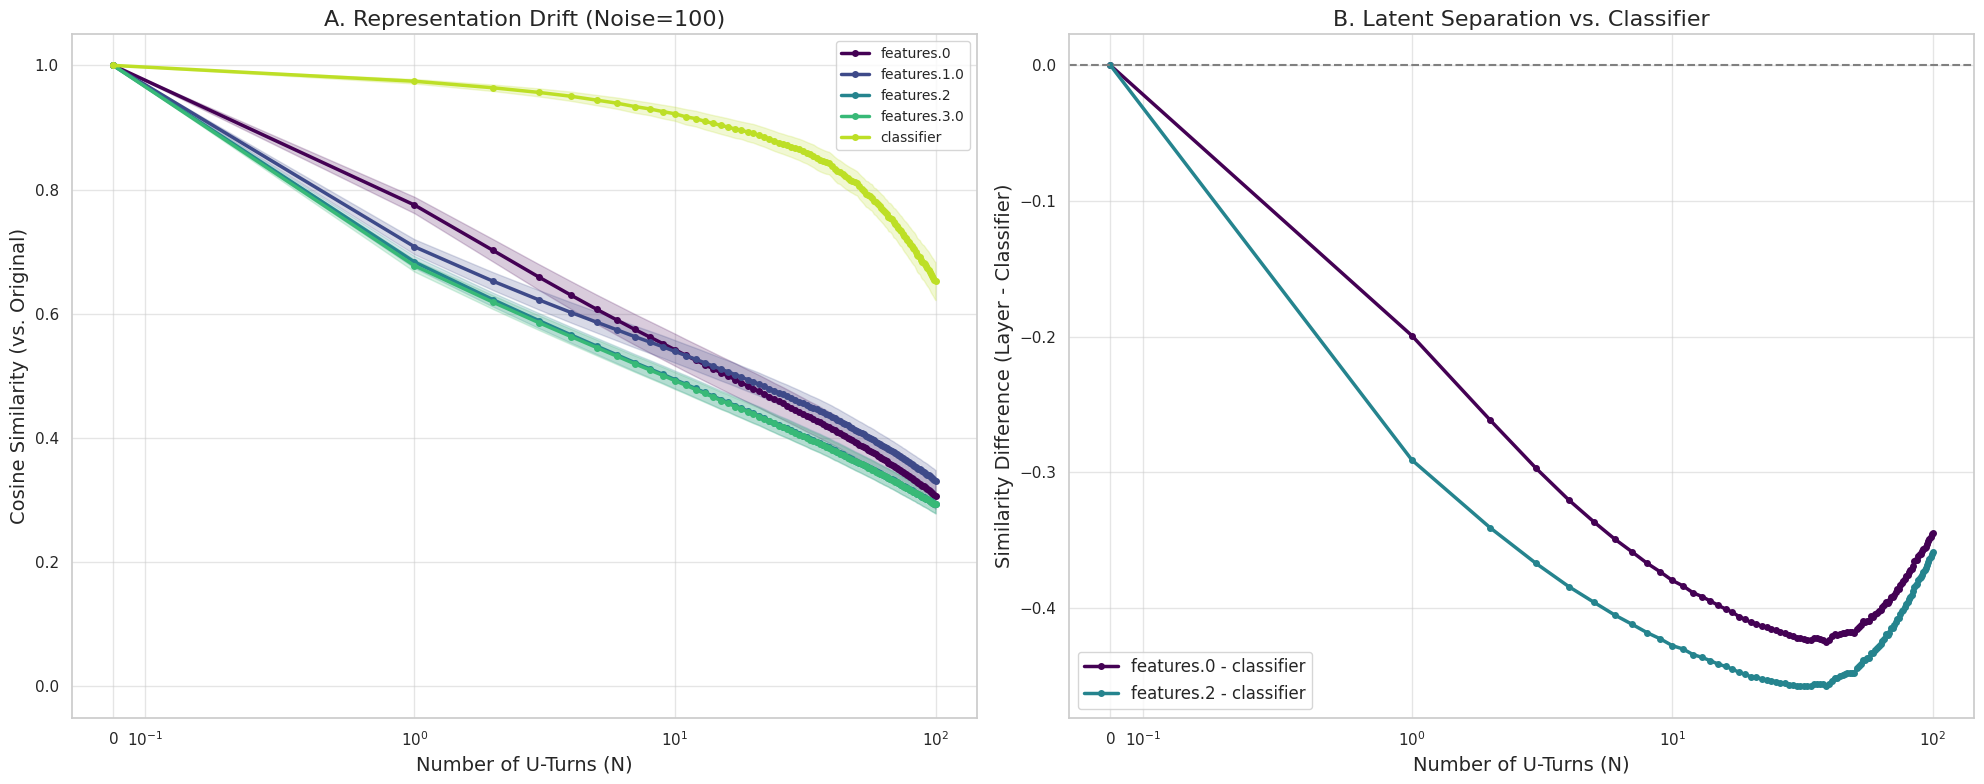

In [5]:
import pickle
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
# 1. Path to your results
BASE_OUTPUT_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"

# 2. Experiment Settings
CLASSIFIER_NAME = "convnext_base"
NOISE_STEP = 100 # Change this to the noise level you want to inspect

# 3. Layers to Plot
#    Adjust these strings to match the keys in your pickle file (e.g. 'stages.0', 'features.0', 'head')
LAYERS_TO_PLOT = [
    "features.0",   # Input / Low Level
    "features.1", 
    "features.2", 
    "features.3",   # High Level
    "classifier"        # Classifier Output
]

# 4. Filter Settings
MIN_SAMPLES_REQUIRED = 5 # Drop steps with fewer than this many successful trajectories

# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
print(f"Analyzing {CLASSIFIER_NAME} at Noise Step {NOISE_STEP}...")

search_pattern = os.path.join(
    BASE_OUTPUT_DIR, 
    CLASSIFIER_NAME, 
    "*", 
    f"noise_{NOISE_STEP}", 
    "sequential_activations_v2.pk"
)

file_list = sorted(glob.glob(search_pattern))
print(f"Found {len(file_list)} image result files.")

if not file_list:
    raise FileNotFoundError("No files found. Check BASE_OUTPUT_DIR and NOISE_STEP.")

global_stats = {}

for filepath in file_list:
    try:
        with open(filepath, 'rb') as f:
            results_by_step = pickle.load(f)
        
        for step in results_by_step:
            layer_data = results_by_step[step]
            for layer in layer_data:
                # Filter layers early to save memory
                if not any(target in layer for target in LAYERS_TO_PLOT):
                    continue
                
                # Average over trajectories for this image
                traj_mean = np.mean(layer_data[layer]['cosine'])
                
                if layer not in global_stats: global_stats[layer] = {}
                if step not in global_stats[layer]: global_stats[layer][step] = []
                
                global_stats[layer][step].append(traj_mean)
                
    except Exception as e:
        print(f"Error reading {filepath}: {e}")

# ---------------------------------------------------------
# 2. VALIDATE STEPS (Your Logic)
# ---------------------------------------------------------
if not global_stats:
    print("No data loaded.")
else:
    # Find valid range based on sample count
    test_layer = list(global_stats.keys())[0]
    all_steps = sorted(global_stats[test_layer].keys())
    
    valid_steps = []
    
    for step in all_steps:
        if len(global_stats[test_layer][step]) >= MIN_SAMPLES_REQUIRED:
            valid_steps.append(step)
    
    if not valid_steps:
        print("Error: No steps met the minimum sample requirement.")
    else:
        print(f"Plotting {len(valid_steps)} steps.")

        # Match specific layer names found in file to your requests
        available_layers = sorted(global_stats.keys())
        ordered_layers = []
        for target in LAYERS_TO_PLOT:
            for layer in available_layers:
                if target in layer:
                    ordered_layers.append(layer)
                    break
        
        # ---------------------------------------------------------
        # 3. PLOT 1: COSINE SIMILARITY vs U-TURNS
        # ---------------------------------------------------------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        colors = plt.cm.viridis(np.linspace(0, 0.9, len(ordered_layers)))
        
        # Dictionary to store mean values for the Separation plot
        layer_means = {l: {} for l in ordered_layers} 

        for i, full_layer_name in enumerate(ordered_layers):
            xs = [0] + valid_steps
            ys = [1.0]
            errs = [0.0]
            
            for step in valid_steps:
                values = np.array(global_stats[full_layer_name][step])
                mean_val = np.mean(values)
                sem_val = np.std(values) / np.sqrt(len(values))
                
                ys.append(mean_val)
                errs.append(sem_val)
                
                # Store for next plot
                layer_means[full_layer_name][step] = mean_val
            
            ax1.plot(xs, ys, marker='o', markersize=4, label=full_layer_name, color=colors[i], linewidth=2.5)
            ax1.fill_between(xs, np.array(ys)-np.array(errs), np.array(ys)+np.array(errs), color=colors[i], alpha=0.2)

        ax1.set_xscale('symlog', linthresh=0.9)
        ax1.set_xlabel("Number of U-Turns (N)", fontsize=14)
        ax1.set_ylabel("Cosine Similarity (vs. Original)", fontsize=14)
        ax1.set_title(f"A. Representation Drift (Noise={NOISE_STEP})", fontsize=16)
        ax1.legend(loc='best', fontsize=10)
        ax1.grid(True, which="major", ls="-", alpha=0.5)
        ax1.grid(True, which="minor", ls=":", alpha=0.2)
        ax1.set_ylim(-0.05, 1.05)

        # ---------------------------------------------------------
        # 4. PLOT 2: LATENT SEPARATION (Difference vs Classifier)
        # ---------------------------------------------------------
        # We calculate: Similarity(Layer X) - Similarity(Classifier)
        # Positive value means Layer X is MORE stable (closer to original) than Classifier.
        
        classifier_layer = ordered_layers[-1] # Assuming last one is head/classifier
        input_layer = ordered_layers[0]       # Assuming first one is input/stages.0
        mid_layer = ordered_layers[len(ordered_layers)//2] 
        
        pairs_to_plot = [input_layer, mid_layer] # Compare these against classifier
        sep_colors = [colors[0], colors[len(ordered_layers)//2]]

        for i, layer in enumerate(pairs_to_plot):
            xs = [0] + valid_steps
            separations = [0.0] # 1.0 - 1.0 = 0
            
            for step in valid_steps:
                sim_layer = layer_means[layer][step]
                sim_class = layer_means[classifier_layer][step]
                separations.append(sim_layer - sim_class)
            
            label_text = f"{layer} - {classifier_layer}"
            ax2.plot(xs, separations, marker='o', markersize=4, label=label_text, color=sep_colors[i], linewidth=2.5)

        ax2.set_xscale('symlog', linthresh=0.9)
        ax2.set_xlabel("Number of U-Turns (N)", fontsize=14)
        ax2.set_ylabel("Similarity Difference (Layer - Classifier)", fontsize=14)
        ax2.set_title(f"B. Latent Separation vs. Classifier", fontsize=16)
        ax2.axhline(0, color='gray', linestyle='--')
        ax2.legend(loc='best', fontsize=12)
        ax2.grid(True, which="major", ls="-", alpha=0.5)
        ax2.grid(True, which="minor", ls=":", alpha=0.2)

        plt.tight_layout()
        plt.show()

Generating Parametric Plots for Noise Step 100...


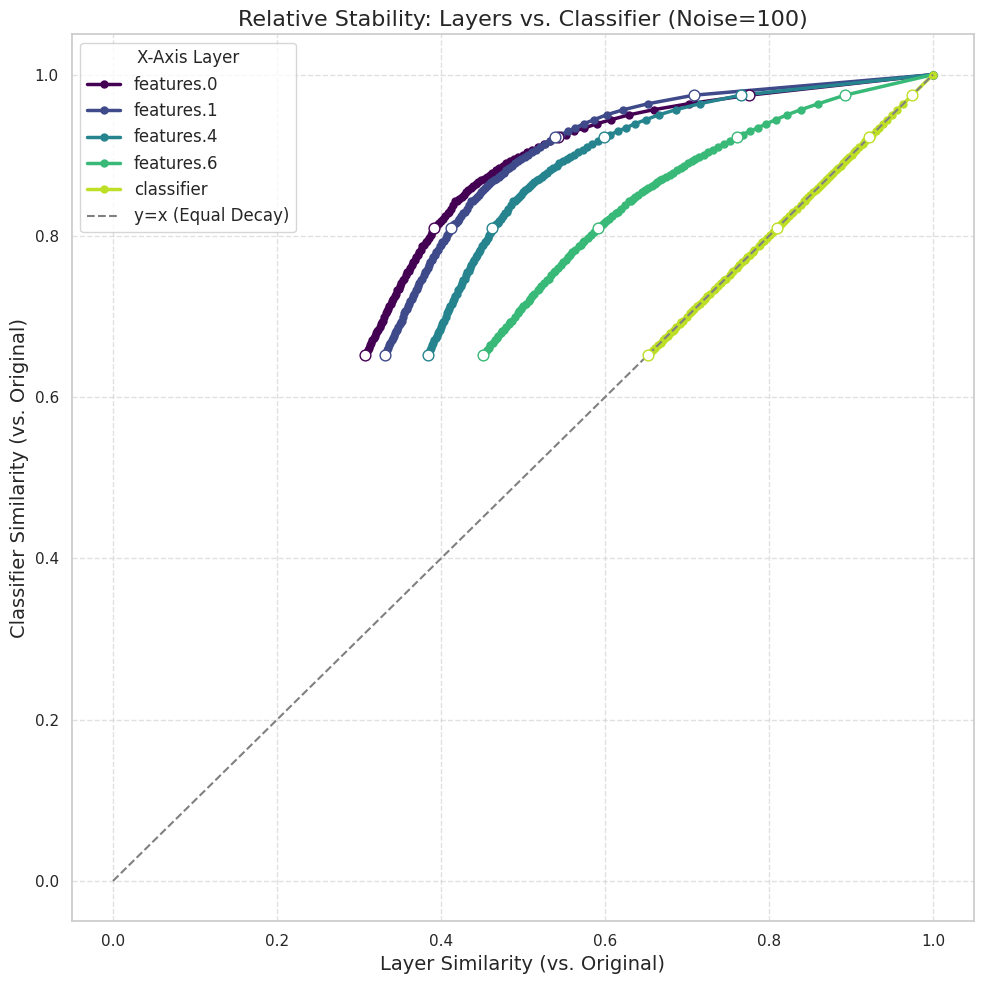

In [6]:
import pickle
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
BASE_OUTPUT_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"
CLASSIFIER_NAME = "convnext_base"
NOISE_STEP = 100 
MIN_SAMPLES_REQUIRED = 5 

# Define the "High Level" reference layer (Y-axis)
CLASSIFIER_LAYER_KEY = "classifier" 

# Define the "Lower Level" layers to compare against (X-axis)
# We will create one curve for each of these
LAYERS_FOR_X_AXIS = [
    "features.0",   # Very Low Level
    "features.1",   # Mid-Low
    "features.4",   # Mid-High
    "features.6",    # High Level (but before head)
    "classifier"
]

# ---------------------------------------------------------
# 1. LOAD DATA (Same robust loading logic)
# ---------------------------------------------------------
print(f"Generating Parametric Plots for Noise Step {NOISE_STEP}...")

search_pattern = os.path.join(
    BASE_OUTPUT_DIR, CLASSIFIER_NAME, "*", f"noise_{NOISE_STEP}", "sequential_activations_v2.pk"
)
file_list = sorted(glob.glob(search_pattern))

if not file_list:
    raise FileNotFoundError("No files found.")

global_stats = {}

for filepath in file_list:
    try:
        with open(filepath, 'rb') as f:
            results_by_step = pickle.load(f)
        
        for step in results_by_step:
            layer_data = results_by_step[step]
            for layer in layer_data:
                # Filter to only keep layers we care about
                if not (any(target in layer for target in LAYERS_FOR_X_AXIS) or CLASSIFIER_LAYER_KEY in layer):
                    continue
                
                traj_mean = np.mean(layer_data[layer]['cosine'])
                
                if layer not in global_stats: global_stats[layer] = {}
                if step not in global_stats[layer]: global_stats[layer][step] = []
                
                global_stats[layer][step].append(traj_mean)      
    except Exception: continue

# ---------------------------------------------------------
# 2. PREPARE PLOTTING DATA
# ---------------------------------------------------------
# Find valid steps
test_layer = list(global_stats.keys())[0]
all_steps = sorted(global_stats[test_layer].keys())
valid_steps = [s for s in all_steps if len(global_stats[test_layer][s]) >= MIN_SAMPLES_REQUIRED]

# Find the full name for the Y-axis layer (Classifier)
full_classifier_name = next((k for k in global_stats.keys() if CLASSIFIER_LAYER_KEY in k), None)
if not full_classifier_name:
    raise ValueError(f"Could not find data for classifier layer: {CLASSIFIER_LAYER_KEY}")

# Calculate Y-axis values (Classifier Similarity)
y_means = [1.0] # t=0
for step in valid_steps:
    y_means.append(np.mean(global_stats[full_classifier_name][step]))
y_means = np.array(y_means)

# ---------------------------------------------------------
# 3. PLOT
# ---------------------------------------------------------
plt.figure(figsize=(10, 10))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(LAYERS_FOR_X_AXIS)))

for i, layer_short in enumerate(LAYERS_FOR_X_AXIS):
    # Find full name
    full_layer_name = next((k for k in global_stats.keys() if layer_short in k), None)
    if not full_layer_name: continue
    
    # Calculate X-axis values (Layer Similarity)
    x_means = [1.0] # t=0
    for step in valid_steps:
        x_means.append(np.mean(global_stats[full_layer_name][step]))
    x_means = np.array(x_means)
    
    # Plot the Curve
    # Points move from (1.0, 1.0) towards (0.0, 0.0) as N increases
    plt.plot(x_means, y_means, '-o', markersize=5, linewidth=2.5, 
             color=colors[i], label=layer_short)
    
    # Mark specific milestones to visualize "Time" along the curve
    milestones = [1, 10, 50, 100]
    # Find indices for milestones (accounting for the t=0 insert)
    milestone_indices = []
    for m in milestones:
        if m in valid_steps:
            idx = valid_steps.index(m) + 1 # +1 for the t=0 at start
            milestone_indices.append(idx)
    
    plt.scatter(x_means[milestone_indices], y_means[milestone_indices], 
                color='white', edgecolor=colors[i], s=60, zorder=5)

# Identity Line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='y=x (Equal Decay)')

plt.xlabel(f"Layer Similarity (vs. Original)", fontsize=14)
plt.ylabel(f"Classifier Similarity (vs. Original)", fontsize=14)
plt.title(f"Relative Stability: Layers vs. Classifier (Noise={NOISE_STEP})", fontsize=16)

# Formatting
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend(title="X-Axis Layer", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

Loading data...
Sequential Loader: Found 35 files for noise 100.
Single U-turn Loader: Found 404 files.


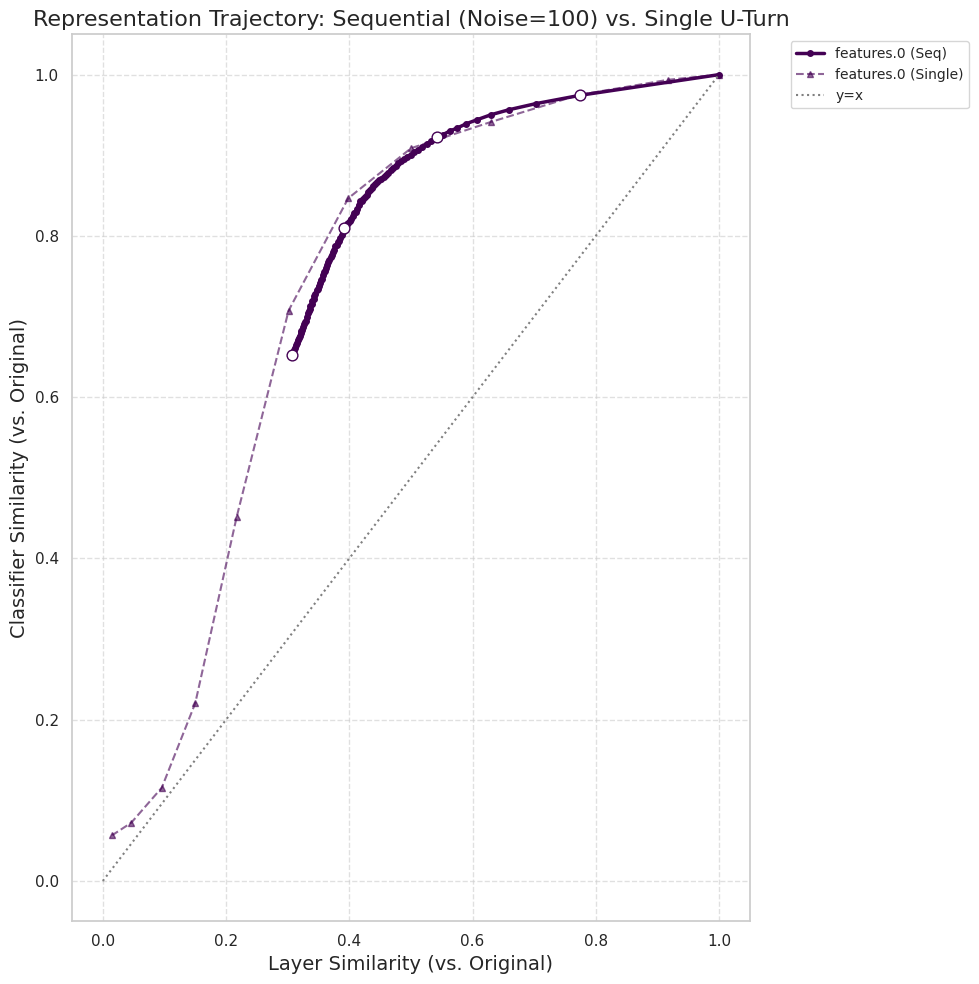

In [20]:
import pickle
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# --- CONFIGURATION ---
# 1. Sequential Data Config (Fixed Noise, Varying N)
SEQ_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"
SEQ_NOISE_STEP = 100
SEQ_MIN_SAMPLES = 5

# 2. Single U-turn Data Config (Varying Noise, Fixed N=1)
# Point this to the ROOT of the single analysis folder
SINGLE_RESULTS_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/single_uturn_analysis_results"

# 3. Common Config
CLASSIFIER_NAME = "convnext_base"
# Note: Use generic names that will match the keys in the pickle file
CLASSIFIER_LAYER_KEY = "classifier" # or "head" depending on what is in your .pk file
LAYERS_FOR_X_AXIS = ["features.0"] #, "features.3", "features.4"]
METRIC = 'cosine'

# ---------------------------------------------------------
# FUNCTION: Load Single U-Turn Data (Corrected for Hierarchical Structure)
# ---------------------------------------------------------
def load_single_uturn_stats(results_dir, classifier_name, metric_key, layers_to_keep):
    """
    Loads data from: results_dir / classifier / * / noise_X / sequential_activations_v2.pk
    Aggregates over images to produce one curve per layer (Noise vs Similarity).
    """
    aggregated_data = {} # layer -> noise -> [val_img1, val_img2...]
    
    # Construct search pattern for the HIERARCHICAL structure
    search_pattern = os.path.join(results_dir, classifier_name, "*", "noise_*", "sequential_activations_v2.pk")
    files = glob.glob(search_pattern)
    
    print(f"Single U-turn Loader: Found {len(files)} files.")
    if not files: return {}

    for filepath in files:
        try:
            # Extract Noise Level from folder name ".../noise_150/..."
            parent_folder = os.path.basename(os.path.dirname(filepath))
            noise_val = int(parent_folder.split('_')[-1])
            
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            
            # We specifically want Step 1 (the single u-turn result)
            # (Step 0 is the reference/identity)
            if 1 not in results: continue
            step_data = results[1]
            
            for layer in step_data:
                # Filter layers
                if not (any(k in layer for k in layers_to_keep) or CLASSIFIER_LAYER_KEY in layer):
                    continue
                
                # Inner Average: Mean over trajectories for THIS image
                traj_scores = step_data[layer][metric_key]
                image_mean = np.mean(traj_scores)
                
                if layer not in aggregated_data: aggregated_data[layer] = {}
                if noise_val not in aggregated_data[layer]: aggregated_data[layer][noise_val] = []
                
                aggregated_data[layer][noise_val].append(image_mean)
                
        except Exception as e:
            continue

    # Process into final x/y arrays
    processed_data = {}
    
    # Get all unique noise levels found across all data
    all_noise_levels = set()
    for layer in aggregated_data:
        all_noise_levels.update(aggregated_data[layer].keys())
    sorted_noise = sorted(list(all_noise_levels))
    
    # Add t=0 baseline
    all_steps = [0] + sorted_noise
    
    for layer in aggregated_data:
        means = [1.0] # t=0
        for n in sorted_noise:
            if n in aggregated_data[layer]:
                # Outer Average: Mean over ALL images
                means.append(np.mean(aggregated_data[layer][n]))
            else:
                means.append(np.nan)
        
        processed_data[layer] = {'x': all_steps, 'y': means}
        
    return processed_data

# ---------------------------------------------------------
# FUNCTION: Load Sequential Data (Same as before)
# ---------------------------------------------------------
def load_sequential_stats(base_dir, classifier, noise_step, min_samples):
    search_pattern = os.path.join(base_dir, classifier, "*", f"noise_{noise_step}", "sequential_activations_v2.pk")
    file_list = sorted(glob.glob(search_pattern))
    
    print(f"Sequential Loader: Found {len(file_list)} files for noise {noise_step}.")
    if not file_list: return {}
    
    raw_stats = {}
    for filepath in file_list:
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            # Find valid steps in this file
            steps = sorted(results.keys())
            
            for step in steps:
                layer_data = results[step]
                for layer in layer_data:
                    # Filter
                    if not (any(k in layer for k in LAYERS_FOR_X_AXIS) or CLASSIFIER_LAYER_KEY in layer):
                        continue
                        
                    val = np.mean(layer_data[layer]['cosine'])
                    if layer not in raw_stats: raw_stats[layer] = {}
                    if step not in raw_stats[layer]: raw_stats[layer][step] = []
                    raw_stats[layer][step].append(val)
        except Exception: continue
        
    processed_data = {}
    if not raw_stats: return {}

    # Determine valid steps based on sample count
    test_layer = list(raw_stats.keys())[0]
    valid_steps = sorted([s for s in raw_stats[test_layer].keys() if len(raw_stats[test_layer][s]) >= min_samples])
    
    all_steps = [0] + valid_steps

    for layer in raw_stats:
        means = [1.0]
        for step in valid_steps:
            means.append(np.mean(raw_stats[layer][step]))
        
        processed_data[layer] = {'x': all_steps, 'y': means}
        
    return processed_data

# ---------------------------------------------------------
# MAIN EXECUTION
# ---------------------------------------------------------
print("Loading data...")
seq_data = load_sequential_stats(SEQ_RESULTS_DIR, CLASSIFIER_NAME, SEQ_NOISE_STEP, SEQ_MIN_SAMPLES)
single_data = load_single_uturn_stats(SINGLE_RESULTS_DIR, CLASSIFIER_NAME, METRIC, LAYERS_FOR_X_AXIS)

if not seq_data:
    print("❌ Error: Sequential data not found.")
if not single_data:
    print("❌ Error: Single U-turn data not found.")

if seq_data and single_data:
    # Find full names in the data
    full_classifier_seq = next((k for k in seq_data.keys() if CLASSIFIER_LAYER_KEY in k), None)
    if not full_classifier_seq:
        print(f"❌ Error: Classifier layer '{CLASSIFIER_LAYER_KEY}' not found in sequential data. Available: {list(seq_data.keys())}")
    else:
        plt.figure(figsize=(10, 10))
        colors = plt.cm.viridis(np.linspace(0, 0.9, len(LAYERS_FOR_X_AXIS)))

        for i, layer_short in enumerate(LAYERS_FOR_X_AXIS):
            # 1. Plot Sequential
            full_layer_seq = next((k for k in seq_data.keys() if layer_short in k), None)
            
            if full_layer_seq:
                x_seq = np.array(seq_data[full_layer_seq]['y'])
                y_seq = np.array(seq_data[full_classifier_seq]['y'])
                
                plt.plot(x_seq, y_seq, '-o', markersize=4, linewidth=2.5, 
                         color=colors[i], label=f"{layer_short} (Seq)")

                # Milestones
                # Assuming steps are 1, 2, 3... indices match
                for m in [1, 10, 50, 100]:
                    if m < len(x_seq):
                         plt.scatter(x_seq[m], y_seq[m], color='white', edgecolor=colors[i], s=60, zorder=5)

            # 2. Plot Single U-Turn
            full_layer_single = next((k for k in single_data.keys() if layer_short in k), None)
            full_classifier_single = next((k for k in single_data.keys() if CLASSIFIER_LAYER_KEY in k), None)
            
            if full_layer_single and full_classifier_single:
                x_single = np.array(single_data[full_layer_single]['y'])
                y_single = np.array(single_data[full_classifier_single]['y'])
                
                plt.plot(x_single, y_single, '--^', markersize=4, linewidth=1.5, 
                         color=colors[i], alpha=0.6, label=f"{layer_short} (Single)")

        plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='y=x')
        plt.xlabel(f"Layer Similarity (vs. Original)", fontsize=14)
        plt.ylabel(f"Classifier Similarity (vs. Original)", fontsize=14)
        plt.title(f"Representation Trajectory: Sequential (Noise={SEQ_NOISE_STEP}) vs. Single U-Turn", fontsize=16)

        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

In [9]:
import pickle
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 8]

# --- PATH CONFIGURATION ---
# 1. Path to Single U-Turn Baseline Results (Varying Noise, N=1)
#    (The output from the 'noise scan' you just ran)
SINGLE_BASE_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/single_uturn_analysis_results"

# 2. Path to Sequential Results (Fixed Noise, Varying N)
#    (The output from the 'sequential' run)
SEQ_BASE_DIR = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/sequential_analysis_results"

# 3. Parameters
CLASSIFIER_NAME = "convnext_base"
SEQ_NOISE_STEP = 100  # The specific noise level to plot for the sequential trajectory

# 4. Layers
CLASSIFIER_LAYER = "classifier" # The Y-axis reference
LAYERS_TO_PLOT = [
    "features.0", 
    "features.1", 
    "features.2", 
    "features.3",
    "features.4",
    "features.5",
    "features.6",
    "features.7"

]

In [10]:
def load_hierarchical_data(base_dir, classifier_name, specific_noise=None):
    """
    Loads data from: base / classifier / * / noise_X / sequential_activations_v2.pk
    
    Args:
        specific_noise (int): If set, only load this noise level. 
                              If None, load all found noise levels.
    
    Returns:
        dict: data[noise_level][layer][step] = [list of means per image]
    """
    aggregated_data = {} 
    
    # Construct search pattern
    if specific_noise is not None:
        noise_pattern = f"noise_{specific_noise}"
    else:
        noise_pattern = "noise_*"
        
    search_pattern = os.path.join(base_dir, classifier_name, "*", noise_pattern, "sequential_activations_v2.pk")
    files = glob.glob(search_pattern)
    
    print(f"Searching: {base_dir} -> Found {len(files)} files.")
    
    for filepath in files:
        try:
            # Extract Noise Level from folder name
            parent_folder = os.path.basename(os.path.dirname(filepath))
            noise_val = int(parent_folder.split('_')[-1])
            
            with open(filepath, 'rb') as f:
                results = pickle.load(f) # dict: step -> layer -> {'cosine': array}
            
            # Initialize structure for this noise level
            if noise_val not in aggregated_data: 
                aggregated_data[noise_val] = {}

            # Iterate through steps (N) in this file
            for step in results:
                step_data = results[step]
                for layer in step_data:
                    # Filter layers to save memory
                    if not (any(k in layer for k in LAYERS_TO_PLOT) or CLASSIFIER_LAYER in layer):
                        continue
                    
                    # Inner Average: Mean over trajectories for THIS image
                    traj_scores = step_data[layer]['cosine']
                    image_mean = np.mean(traj_scores)
                    
                    if layer not in aggregated_data[noise_val]:
                        aggregated_data[noise_val][layer] = {}
                    if step not in aggregated_data[noise_val][layer]:
                        aggregated_data[noise_val][layer][step] = []
                        
                    aggregated_data[noise_val][layer][step].append(image_mean)
                
        except Exception as e:
            continue
            
    return aggregated_data

Searching: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/single_uturn_analysis_results -> Found 404 files.


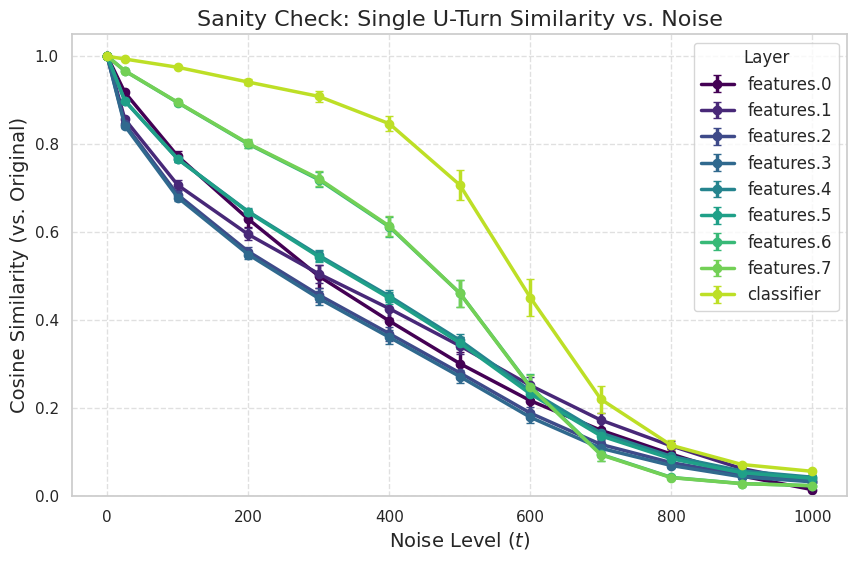

In [11]:
# Load ALL noise levels from the Single U-turn baseline
single_data_raw = load_hierarchical_data(SINGLE_BASE_DIR, CLASSIFIER_NAME, specific_noise=None)

if not single_data_raw:
    print("❌ No Single U-Turn data found!")
else:
    plt.figure(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(LAYERS_TO_PLOT) + 1)) # +1 for classifier

    # Combine requested layers + classifier for this plot
    plot_layers = LAYERS_TO_PLOT + [CLASSIFIER_LAYER]
    
    # Get available noise levels (X-axis)
    # We look at the first layer to find available noise keys
    first_layer_key = list(single_data_raw.keys())[0] # Just a random noise key to start
    # We need to pivot: We have data[noise][layer][step]. We want x=noise, y=value at step 1.
    
    noise_levels = sorted(single_data_raw.keys())
    
    # Add t=0 baseline
    x_axis = [0] + noise_levels

    for i, layer_short in enumerate(plot_layers):
        y_axis = [1.0] # t=0
        errs = [0.0]
        
        valid_layer = False
        
        for noise in noise_levels:
            # Find the full layer name in the data
            full_layer = next((k for k in single_data_raw[noise].keys() if layer_short in k), None)
            
            if full_layer and 1 in single_data_raw[noise][full_layer]:
                valid_layer = True
                values = single_data_raw[noise][full_layer][1] # Step 1
                
                # Outer Average over Images
                y_axis.append(np.mean(values))
                errs.append(np.std(values) / np.sqrt(len(values)))
            else:
                # Handle missing data points if necessary
                y_axis.append(np.nan)
                errs.append(0)
        
        if valid_layer:
            plt.errorbar(x_axis, y_axis, yerr=errs, marker='o', capsize=3, 
                         label=layer_short, color=colors[i], linewidth=2.5)

    plt.title(f"Sanity Check: Single U-Turn Similarity vs. Noise", fontsize=16)
    plt.xlabel("Noise Level ($t$)", fontsize=14)
    plt.ylabel("Cosine Similarity (vs. Original)", fontsize=14)
    plt.legend(title="Layer", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

Searching: /home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/scripts/single_uturn_analysis_results -> Found 404 files.
Found 41 layers: ['classifier', 'features.0', 'features.1.0', 'features.1.1', 'features.1.2', 'features.2', 'features.3.0', 'features.3.1', 'features.3.2', 'features.4', 'features.5.0', 'features.5.1', 'features.5.10', 'features.5.11', 'features.5.12', 'features.5.13', 'features.5.14', 'features.5.15', 'features.5.16', 'features.5.17', 'features.5.18', 'features.5.19', 'features.5.2', 'features.5.20', 'features.5.21', 'features.5.22', 'features.5.23', 'features.5.24', 'features.5.25', 'features.5.26', 'features.5.3', 'features.5.4', 'features.5.5', 'features.5.6', 'features.5.7', 'features.5.8', 'features.5.9', 'features.6', 'features.7.0', 'features.7.1', 'features.7.2']


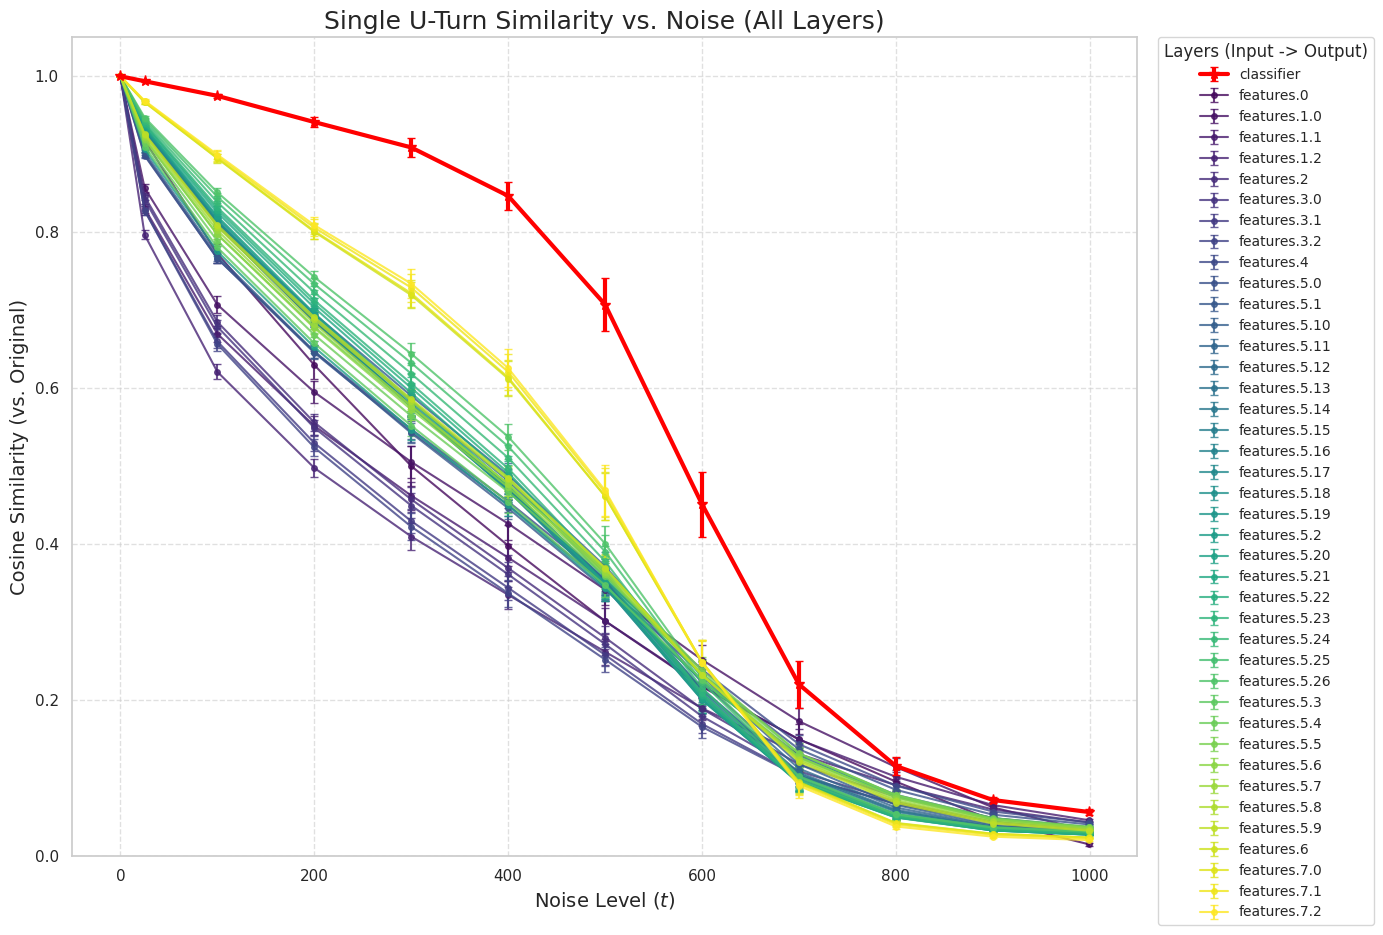

In [12]:
# Load ALL noise levels from the Single U-turn baseline
single_data_raw = load_hierarchical_data(SINGLE_BASE_DIR, CLASSIFIER_NAME, specific_noise=None)

if not single_data_raw:
    print("❌ No Single U-Turn data found!")
else:
    # --- 1. Auto-Discover All Layers ---
    # We look at the first available noise level to get the list of keys
    first_noise_key = list(single_data_raw.keys())[0]
    all_layer_names = sorted(list(single_data_raw[first_noise_key].keys()))
    
    print(f"Found {len(all_layer_names)} layers: {all_layer_names}")
    
    # --- 2. Setup Plot ---
    plt.figure(figsize=(14, 10))
    # Create a color map that spans the full range of layers
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_layer_names)))
    
    noise_levels = sorted(single_data_raw.keys())
    x_axis = [0] + noise_levels

    # --- 3. Plot Loop ---
    for i, full_layer_name in enumerate(all_layer_names):
        y_axis = [1.0] # t=0
        errs = [0.0]
        
        valid_layer = False
        
        for noise in noise_levels:
            if full_layer_name in single_data_raw[noise] and 1 in single_data_raw[noise][full_layer_name]:
                valid_layer = True
                values = single_data_raw[noise][full_layer_name][1] # Step 1
                
                y_axis.append(np.mean(values))
                errs.append(np.std(values) / np.sqrt(len(values)))
            else:
                y_axis.append(np.nan)
                errs.append(0)
        
        if valid_layer:
            # Check if it's a special layer (classifier) to make it bold
            if "classifier" in full_layer_name or "head" in full_layer_name:
                plt.errorbar(x_axis, y_axis, yerr=errs, marker='*', markersize=8, capsize=3, 
                             label=full_layer_name, color='red', linewidth=3, zorder=10)
            else:
                plt.errorbar(x_axis, y_axis, yerr=errs, marker='o', markersize=4, capsize=3, 
                             label=full_layer_name, color=colors[i], linewidth=1.5, alpha=0.8)

    # --- 4. Formatting ---
    plt.title(f"Single U-Turn Similarity vs. Noise (All Layers)", fontsize=18)
    plt.xlabel("Noise Level ($t$)", fontsize=14)
    plt.ylabel("Cosine Similarity (vs. Original)", fontsize=14)
    
    # Place legend outside to avoid clutter
    plt.legend(title="Layers (Input -> Output)", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small', borderaxespad=0.)
    
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [5]:
y_axis

[1.0,
 0.9738664,
 0.84864223,
 0.11696002,
 0.90877724,
 0.84666383,
 0.70738506,
 0.45135057,
 0.22038132,
 0.11563251,
 0.07210832,
 0.05673034]

In [6]:
import os
import glob
import pickle

# --- CONFIGURATION ---
# The specific image you want to check
IMAGE_NAME = "ILSVRC2012_val_00000487"

# The noise levels that are showing up as NaN
NOISE_LEVELS_TO_CHECK = [25, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

# Paths
RAW_BASE = "/work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline"
ANALYSIS_BASE = "single_uturn_analysis_results"
CLASSIFIER = "convnext_base"

def check_status():
    print(f"--- DIAGNOSING: {IMAGE_NAME} ---")
    print(f"Raw Data Path: {RAW_BASE}")
    print(f"Analysis Path: {ANALYSIS_BASE}")
    print("-" * 60)
    print(f"{'Noise':<6} | {'Raw Folder':<12} | {'Images (0,1)':<15} | {'Analysis File':<15} | {'Data Content'}")
    print("-" * 60)

    for noise in NOISE_LEVELS_TO_CHECK:
        status_raw = "❌"
        status_img = "❌"
        status_ana = "❌"
        status_content = "N/A"

        # 1. Check Raw Data Folder
        raw_noise_path = os.path.join(RAW_BASE, IMAGE_NAME, f"noise_step_{noise}")
        if os.path.isdir(raw_noise_path):
            status_raw = "✅"
            
            # 2. Check for Images in Trajectory 0
            traj_path = os.path.join(raw_noise_path, "trajectory_000")
            if os.path.isdir(traj_path):
                # Check for Start (000) and Final (001)
                has_start = os.path.exists(os.path.join(traj_path, "uturn_000.jpeg")) or \
                            os.path.exists(os.path.join(traj_path, "uturn_000.png"))
                has_final = os.path.exists(os.path.join(traj_path, "uturn_001.jpeg")) or \
                            os.path.exists(os.path.join(traj_path, "uturn_001.png"))
                
                if has_start and has_final:
                    status_img = "✅"
                elif has_start:
                    status_img = "Start Only"
                else:
                    status_img = "Empty"
            else:
                status_img = "No Traj Dir"
        
        # 3. Check Analysis File
        ana_path = os.path.join(ANALYSIS_BASE, CLASSIFIER, IMAGE_NAME, f"noise_{noise}", "sequential_activations_v2.pk")
        print(ana_path)
        if os.path.exists(ana_path):
            status_ana = "✅"
            
            # 4. Check Content (Is step 1 actually inside?)
            try:
                with open(ana_path, 'rb') as f:
                    data = pickle.load(f)
                if 1 in data:
                    # Check if keys like 'cosine' exist inside
                    layer_keys = list(data[1].keys())
                    if layer_keys and 'cosine' in data[1][layer_keys[0]]:
                         status_content = "✅ Valid"
                    else:
                         status_content = "❌ Bad Keys"
                else:
                    status_content = "❌ No Step 1"
            except Exception as e:
                status_content = "❌ Corrupt"
        
        print(f"{noise:<6} | {status_raw:<12} | {status_img:<15} | {status_ana:<15} | {status_content}")

if __name__ == "__main__":
    check_status()

--- DIAGNOSING: ILSVRC2012_val_00000487 ---
Raw Data Path: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline
Analysis Path: single_uturn_analysis_results
------------------------------------------------------------
Noise  | Raw Folder   | Images (0,1)    | Analysis File   | Data Content
------------------------------------------------------------
single_uturn_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_25/sequential_activations_v2.pk
25     | ✅            | ✅               | ❌               | N/A
single_uturn_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_100/sequential_activations_v2.pk
100    | ✅            | ✅               | ❌               | N/A
single_uturn_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_200/sequential_activations_v2.pk
200    | ✅            | ✅               | ❌               | N/A
single_uturn_analysis_results/convnext_base/ILSVRC2012_val_00000487/noise_300/sequential_activations_v2.pk
300    | ✅     

In [10]:
import os
import shutil
import glob

# --- CONFIGURATION ---
BASE_DIR = "/work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline"
NOISE_LEVELS_TO_DELETE = [25, 100, 200]

print(f"Scanning {BASE_DIR}...")
print(f"Targeting noise levels: {NOISE_LEVELS_TO_DELETE}")

# Find all image directories
image_dirs = sorted(glob.glob(os.path.join(BASE_DIR, "ILSVRC*")))

print(f"Found {len(image_dirs)} image directories.")

deleted_count = 0

for img_dir in image_dirs:
    for noise in NOISE_LEVELS_TO_DELETE:
        noise_folder = os.path.join(img_dir, f"noise_step_{noise}")
        
        if os.path.exists(noise_folder):
            print(f"Removing: {noise_folder}")
            try:
                shutil.rmtree(noise_folder)
                deleted_count += 1
            except Exception as e:
                print(f"Error removing {noise_folder}: {e}")

print("-" * 40)
print(f"Cleanup complete. Removed {deleted_count} folders.")
print("You can now re-run the single U-turn generation for steps 25, 100, 200.")

Scanning /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline...
Targeting noise levels: [25, 100, 200]
Found 32 image directories.
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000487/noise_step_25
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000487/noise_step_100
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000487/noise_step_200
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000681/noise_step_25
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000681/noise_step_100
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000681/noise_step_200
Removing: /work/pcsl/Noam/sequential_diffusion/results/single_uturn_baseline/ILSVRC2012_val_00000729/noise_step_25
Removing: /work/pcsl/Noam/sequential_diffusio